
02_model_training.ipynb : Modélisation et Tracking MLflow

 **Objectif :** Entraîner une baseline et un modèle avancé, en gérant le déséquilibre des classes et en traquant les performances (notamment le coût métier) via MLflow.



In [6]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from mlflow.models.signature import infer_signature
import sys
import os
import lightgbm as lgb
import xgboost as xgb

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from model_utils import (
    prepare_data_for_training, 
    train_cv_and_log, 
    plot_business_cost_threshold,
    optimize_hyperparameters_optuna,
    optimize_hyperparameters_xgboost,
    export_model_to_folder
)

from metrics import custom_business_cost

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of model_utils failed: Traceback (most recent call last):
  File "c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\IPython\extensions\autoreload.py", line 322, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 546, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "C:\Users\lepot\AppData\Local\Programs\Python\Python312\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f in position 7188: character maps to <undefined>
]


## Configuration mlflow
La fonction `prepare_data_for_training` charge les CSV, nettoie les noms de colonnes (pour éviter l'erreur JSON LightGBM), gère les infinis, et effectue le split stratifié.

In [2]:
EXPERIMENT_NAME = "Data_Analisis_Credit_Scoring"
mlflow.set_tracking_uri("file:../mlruns")

PATH_TRAIN = '../datasets/final/train_enriched.csv'
PATH_LABELS = '../datasets/final/train_labels.csv'

X_train, X_val, y_train, y_val = prepare_data_for_training(PATH_TRAIN, PATH_LABELS)

print(f"Données chargées. Train shape: {X_train.shape}")

Chargement des données...
Nettoyage des noms de colonnes...
Split Train/Validation (Stratifié)...
Données chargées. Train shape: (238008, 1845)


In [6]:
X_train.shape

(238008, 1845)

## Validation croisée avec Baseline, LightGBM et XGBoost
Nous comparons la robustesse des modèles sur 5 plis (folds).

#### MODELE : BASELINE (Régression Logistique)
Pipeline nécessaire pour gérer les NaN
On utilise X_train pour la CV (le set de validation final X_val est gardé pour l'optimisation du seuil)

In [7]:
pipe_lr = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(C=1.0, class_weight='balanced', max_iter=500))
])

print("\n--- Cross-Validation: Baseline ---")
model_lr_cv, cost_lr = train_cv_and_log(
    model=pipe_lr, X=X_train, y=y_train,
    experiment_name="Credit_Scoring_Baselines",
    run_name="Baseline_LogReg",       
    model_name="Credit_Scoring_LogReg",
    description="Baseline linéaire simple.",
    tags={"type": "baseline", "algo": "linear"}
)

c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)
2025/12/12 22:51:21 INFO mlflow.tracking.fluent: Experiment with name 'Credit_Scoring_Baselines' does not exist. Creating a new experiment.



--- Cross-Validation: Baseline ---
--- Cross-Validation (5 folds) : Baseline_LogReg ---


c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
   

  >> Moyenne CV: Coût=24160.4 | AUC=0.772
  >> Entraînement final sur l'ensemble du dataset...


c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way

  ✅ Modèle loggé (Run ID: c1ebbbe7b42b409ab243c95fbaf8d697)
  ✅ Modèle enregistré dans le Registry: Credit_Scoring_LogReg (v1)


Created version '1' of model 'Credit_Scoring_LogReg'.


#### MODELE : XGBoost

In [ ]:
ratio_equilibrage = (y_train == 0).sum() / (y_train == 1).sum()

xg = xgb.XGBClassifier(
    objective='binary:logistic', 
    scale_pos_weight=ratio_equilibrage,
    n_estimators=300,             
    learning_rate=0.05,                                 
    n_jobs=3,                     
    random_state=42
)

print("\n--- Cross-Validation: XGBoost ---")
model_xgb_cv, cost_xgb =train_cv_and_log(
    model=xg, X=X_train, y=y_train,
    experiment_name="Credit_Scoring_Baselines",
    run_name="Baseline_XGBoost",
    model_name="Credit_Scoring_XGBoost", 
    description="Modèle XGBoost de base, sans hyperparamètres optimisés",
    tags={"type": "baseline", "algo": "tree"}
)


--- Cross-Validation: XGBoost ---
--- Cross-Validation (5 folds) : Baseline_XGBoost ---
  >> Moyenne CV: Coût=23681.4 | AUC=0.782
  >> Entraînement final sur l'ensemble du dataset...


c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/12 23:46:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Successfully registered model 'Credit_Scoring_XGBoost'.
2025/12/12 23:47:00 WARNING mlflow.tracking._

  ✅ Modèle loggé (Run ID: 58c2fdfd0ee643059f16987d629720b4)
  ✅ Modèle enregistré dans le Registry: Credit_Scoring_XGBoost (v1)


Created version '1' of model 'Credit_Scoring_XGBoost'.


On utilise `optuna` pour rechercher les meilleurs hyperparamètres de XGBoost.

In [ ]:
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.5,
    stratify=y_train,
    random_state=42
)

if mlflow.active_run():
    mlflow.end_run()

print("Lancement de l'optimisation Optuna...")
best_params = optimize_hyperparameters_xgboost(
    X_sample, 
    y_sample, 
    experiment_name=EXPERIMENT_NAME, 
    n_trials=3
)

In [29]:
print(best_params)

{'learning_rate': 0.014329692248645892, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 3.9524244509408835, 'subsample': 0.6642026006490762, 'colsample_bytree': 0.9579861455095176, 'reg_alpha': 0.0013910953177793477, 'reg_lambda': 5.414443052033548, 'n_estimators': 825, 'objective': 'binary:logistic', 'eval_metric': 'auc', 'scale_pos_weight': np.float64(11.520252498684902)}


Meilleurs paramètres trouvés 

In [7]:
print("Utilisation des paramètres manuels ...")
ratio_equilibrage = (y_train == 0).sum() / (y_train == 1).sum()
fixed_params = {
    'learning_rate': 0.012869177845618215, 
    'max_depth': 3, 'min_child_weight': 6, 
    'gamma': 4.337049477691507, 
    'subsample': 0.879838115636258, 
    'colsample_bytree': 0.5121645433524673, 
    'reg_alpha': 0.0022522357241632762, 
    'reg_lambda': 6.918217406817744e-06, ''
    'n_estimators': 894, 
    'objective': 'binary:logistic',
    'scale_pos_weight':ratio_equilibrage,
    'n_jobs':-1,              
    'random_state':42,
    'eval_metric':'auc' 
}

Utilisation des paramètres manuels ...


In [12]:
fixed_params= {
    'learning_rate': 0.04400582813531681, 
    'max_depth': 3, 'min_child_weight': 3, 
    'gamma': 3.1826123101824915, 
    'subsample': 0.6888658996066791, 
    'colsample_bytree': 0.7324941399326785, 
    'reg_alpha': 0.005835037378532085, ''
    'reg_lambda': 5.981644864209042e-07, 
    'n_estimators': 997,
    'objective': 'binary:logistic',
    'scale_pos_weight':ratio_equilibrage,
    'n_jobs':-1,              
    'random_state':42,
    'eval_metric':'auc'}

In [ ]:
print("\nEntraînement du modèle final XGBoost...")

best_xgb = xgb.XGBClassifier(
    **best_params,          
    early_stopping_rounds=100
)

best_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=1
)
print("\n--- Évaluation du Modèle ---")
y_val_proba = best_xgb.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_proba)
print(f"ROC AUC Score : {auc_score:.4f}")


Entraînement du modèle final XGBoost...


NameError: name 'best_params' is not defined

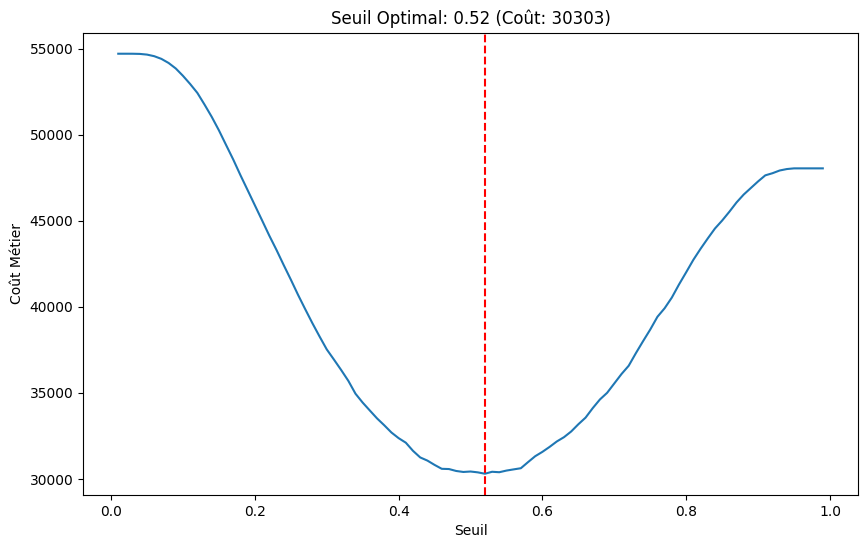

In [14]:
fig, best_thresh = plot_business_cost_threshold(y_val, y_val_proba)
plt.show()

On sauvegarde le modele final de XGBoost dans MLflow en utilisant export_model_to_folder() pour exporter vers model/

In [15]:
print(f"\n>>> MODÈLE FINAL XGBOOST OPTIMISÉ <<<")
print(f"Seuil de décision : {best_thresh:.3f}")

mlflow.set_experiment(EXPERIMENT_NAME)
with mlflow.start_run(run_name="Final_Model_XGBOOST"):
    mlflow.log_params(fixed_params)
    mlflow.log_param("optimal_threshold", best_thresh)
    
    y_pred_optimal = (y_val_proba >= best_thresh).astype(int)
    from metrics import get_metrics
    metrics = get_metrics(y_val, y_pred_optimal, y_val_proba)
    mlflow.log_metrics(metrics)
    
    mlflow.log_figure(fig, "business_cost_curve.png")
    
    signature = infer_signature(X_train, best_xgb.predict(X_train))
    mlflow.sklearn.log_model(
        best_xgb, 
        "modelXGB",  # Nom de l'artefact dans MLflow 
        signature=signature,
        input_example=X_train.iloc[:5]
    )
    
    final_run_id = mlflow.active_run().info.run_id
    print(f"\nModèle loggé dans MLflow avec run_id: {final_run_id}")
    print(f"   Utilisez export_model_to_folder(run_id='{final_run_id}') pour exporter vers model/")


>>> MODÈLE FINAL XGBOOST OPTIMISÉ <<<
Seuil de décision : 0.520


c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/13 12:15:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Modèle loggé dans MLflow avec run_id: 96cdd75a78ba4fae80305e4c734ef773
   Utilisez export_model_to_folder(run_id='96cdd75a78ba4fae80305e4c734ef773') pour exporter vers model/


#### MODELE : LightGBM (Avancé)

In [3]:
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    class_weight='balanced',
    n_jobs=3,
    random_state=42,
    verbose=-1
)

print("\n--- Cross-Validation: LightGBM ---")
model_lgbm_cv, cost_lgbm = train_cv_and_log(
    model=lgbm, X=X_train, y=y_train,
    experiment_name="Credit_Scoring_Baselines",
    run_name="Baseline_LightGBM",
    model_name="Credit_Scoring_LGBM",
    description="LightGBM rapide.",
    tags={"type": "baseline", "algo": "tree"}
)


--- Cross-Validation: LightGBM ---


c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


--- Cross-Validation (5 folds) : Baseline_LightGBM ---
  >> Moyenne CV: Coût=23320.6 | AUC=0.785
  >> Entraînement final sur l'ensemble du dataset...


c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/13 14:00:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\mathi\OneDrive\Bureau\ESAIP\ING4\MAJEUR\Majeur_IA310\lib\site-packages\mlflow\tracking\_mode

  ✅ Modèle loggé (Run ID: 855167ab54664aa6a3c5c6c9f895bd22)
  ✅ Modèle enregistré dans le Registry: Credit_Scoring_LGBM (v1)


Created version '1' of model 'Credit_Scoring_LGBM'.


On utilise `optuna` pour rechercher les meilleurs hyperparamètres de LightGBM.

In [12]:
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train,
    train_size=0.2,
    stratify=y_train,
    random_state=42
)

if mlflow.active_run():
    mlflow.end_run()

print("Lancement de l'optimisation Optuna...")
best_params = optimize_hyperparameters_optuna(
    X_sample, 
    y_sample, 
    experiment_name=EXPERIMENT_NAME, 
    n_trials=50
)

[I 2025-12-13 16:02:07,360] A new study created in memory with name: Data_Analisis_Credit_Scoring


Lancement de l'optimisation Optuna...
--- Optimisation Optuna LightGBM (50 essais) ---


[I 2025-12-13 16:04:33,293] Trial 0 finished with value: 0.7678489409444086 and parameters: {'n_estimators': 400, 'learning_rate': 0.010305098082335064, 'num_leaves': 39, 'max_depth': 13, 'reg_alpha': 0.24737018135154515, 'reg_lambda': 2.9460700594443248e-08, 'colsample_bytree': 0.7544479409866335, 'subsample': 0.5573442873357755}. Best is trial 0 with value: 0.7678489409444086.
[I 2025-12-13 16:07:15,959] Trial 1 finished with value: 0.7238238742578184 and parameters: {'n_estimators': 989, 'learning_rate': 0.08858558137645979, 'num_leaves': 22, 'max_depth': 7, 'reg_alpha': 0.029451126014568004, 'reg_lambda': 0.0001980111461022536, 'colsample_bytree': 0.9808922429781439, 'subsample': 0.8924041900694963}. Best is trial 0 with value: 0.7678489409444086.
[I 2025-12-13 16:09:39,460] Trial 2 finished with value: 0.767943349910563 and parameters: {'n_estimators': 476, 'learning_rate': 0.014299226026607601, 'num_leaves': 32, 'max_depth': 11, 'reg_alpha': 1.1814201817122138e-07, 'reg_lambda': 

Génération des graphiques d'analyse...
Meilleurs params: {'n_estimators': 476, 'learning_rate': 0.014299226026607601, 'num_leaves': 32, 'max_depth': 11, 'reg_alpha': 1.1814201817122138e-07, 'reg_lambda': 3.7489531147629093e-05, 'colsample_bytree': 0.9855460683081549, 'subsample': 0.5859902620083766}


Meilleurs paramètres trouvés 

On relance le modele LightGBM mais optimisé.

In [7]:
fixed_params = {
    'n_estimators': 536,
    'learning_rate': 0.0146,
    'num_leaves': 53,
    'max_depth': 11,
    'reg_alpha': 6.132,
    'reg_lambda': 1.45e-07,
    'colsample_bytree': 0.915,
    'subsample': 0.977,
    'is_unbalance': True,
    'n_jobs': 3,
    'random_state': 42
}

# Créer le modèle avec les paramètres optimisés
lgbm_optimized = LGBMClassifier(**fixed_params)

# Utiliser train_cv_and_log (fait tout : CV + entraînement final + logging MLflow)
print("\n--- Cross-Validation: LightGBM Optimisé ---")
model_lgbm_optimized, cost_lgbm_optimized = train_cv_and_log(
    model=lgbm_optimized,
    X=X_train,
    y=y_train,
    experiment_name="Credit_Scoring_Baselines",
    run_name="LightGBM_Optimized",
    model_name="Credit_Scoring_LGBM_Optimized",
    description="LightGBM optimisé avec Optuna (test de la fonction cv and log)",
    tags={"type": "optimized", "algo": "tree"}
)


--- Cross-Validation: LightGBM Optimisé ---
--- Cross-Validation (5 folds) : LightGBM_Optimized ---
[LightGBM] [Info] Number of positive: 15371, number of negative: 175035
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.395266 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211063
[LightGBM] [Info] Number of data points in the train set: 190406, number of used features: 1837
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080727 -> initscore=-2.432503
[LightGBM] [Info] Start training from score -2.432503


KeyError: 'f1_score'

In [15]:
print("\nEntraînement du modèle final LightGBM...")
best_lgbm = LGBMClassifier(
    **fixed_params,          
    class_weight='balanced',
    n_jobs=-1,              
    random_state=42,
    verbose=1
)

best_lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=200)]
)
print("\n--- Évaluation du Modèle ---")
y_val_proba = best_lgbm.predict_proba(X_val)[:, 1]
auc_score = roc_auc_score(y_val, y_val_proba)
print(f"ROC AUC Score : {auc_score:.4f}")


Entraînement du modèle final LightGBM...
[LightGBM] [Info] Number of positive: 19214, number of negative: 218794
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.218341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 211255
[LightGBM] [Info] Number of data points in the train set: 238008, number of used features: 1837
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.762079	valid_0's binary_logloss: 0.566719
[400]	valid_0's auc: 0.77572	valid_0's binary_logloss: 0.53715
Did not meet early stopping. Best iteration is:
[536]	valid_0's auc: 0.779321	valid_0's binary_logloss: 0.524191

--- Évaluation du Modèle ---
ROC AUC Score : 0.7793


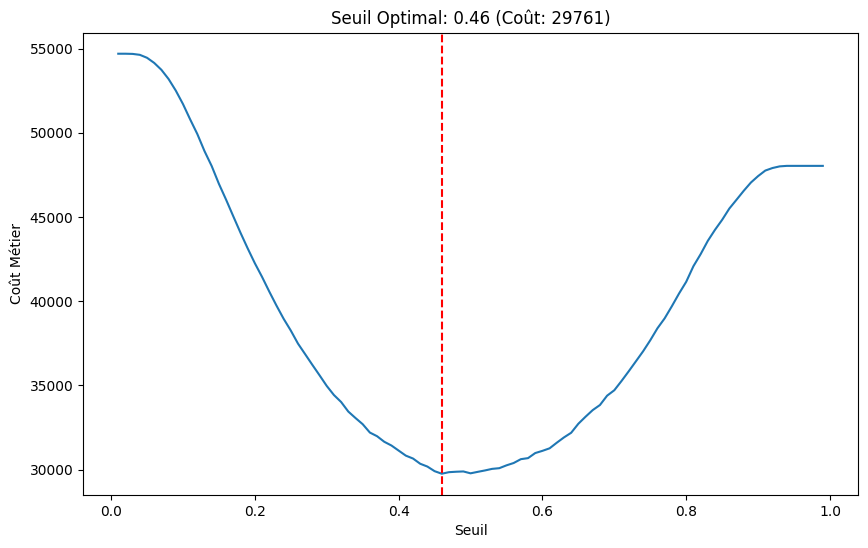

In [38]:
fig, best_thresh = plot_business_cost_threshold(y_val, y_val_proba)
plt.show()

On sauvegarde le modele final dans MLflow en utilisant export_model_to_folder() pour exporter vers model/

In [ ]:
print(f"\n>>> MODÈLE FINAL OPTIMISÉ <<<")
print(f"Seuil de décision : {best_thresh:.3f}")

mlflow.set_experiment(EXPERIMENT_NAME)
with mlflow.start_run(run_name="Final_Model_Optuna"):
    mlflow.log_params(fixed_params)
    mlflow.log_param("optimal_threshold", best_thresh)
    
    y_pred_optimal = (y_val_proba >= best_thresh).astype(int)
    from metrics import get_metrics
    metrics = get_metrics(y_val, y_pred_optimal, y_val_proba)
    mlflow.log_metrics(metrics)
    
    fig_filename = "business_cost_curve_"+ final_run_id+".png"
    fig.savefig("../reports/figures/" + fig_filename)
    mlflow.log_artifact(fig_filename)   
    
    signature = infer_signature(X_train, best_lgbm.predict(X_train))
    mlflow.sklearn.log_model(
        best_lgbm, 
        "model",  # Nom de l'artefact dans MLflow 
        signature=signature,
        input_example=X_train.iloc[:5]
    )
    
    final_run_id = mlflow.active_run().info.run_id
    print(f"\nModèle loggé dans MLflow avec run_id: {final_run_id}")
    print(f"   Utilisez export_model_to_folder(run_id='{final_run_id}') pour exporter vers model/")


>>> MODÈLE FINAL OPTIMISÉ <<<
Seuil de décision : 0.460


c:\Users\lepot\Documents\dataAnalysis\dataAnalysis\.venv\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/12/12 21:09:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Modèle loggé dans MLflow avec run_id: 0907206f98954aa1899be7f2b20958d8
   Utilisez export_model_to_folder(run_id='0907206f98954aa1899be7f2b20958d8') pour exporter vers model/


#### Historigramme des probabilités et comparaison
On effectue la recherche du seuil avec `thresholds`.

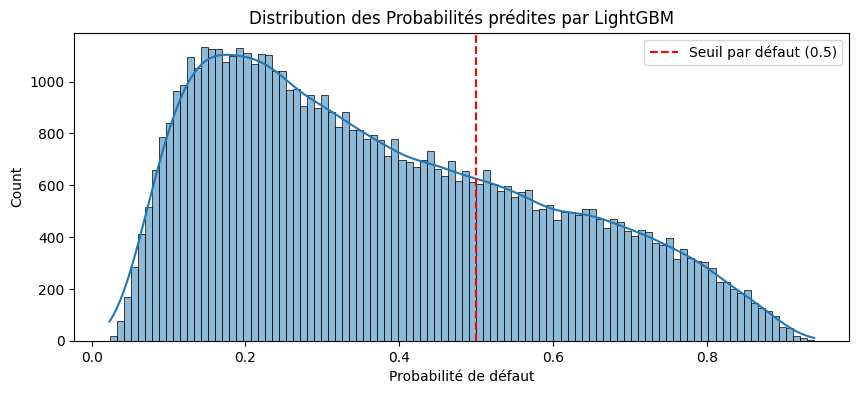

Probabilité Min: 0.0234
Probabilité Moyenne: 0.3793
Probabilité Max: 0.9395

--- RÉSULTAT CORRIGÉ ---
Seuil Optimal Réel : 0.460
Coût Minimum : 29761
Coût avec seuil 0.50 : 29785
Économie réalisée : 24 points

--- Performance au Seuil Optimal ---
              precision    recall  f1-score   support

           0       0.97      0.69      0.81     54699
           1       0.17      0.73      0.28      4804

    accuracy                           0.70     59503
   macro avg       0.57      0.71      0.54     59503
weighted avg       0.90      0.70      0.77     59503



In [40]:
y_val_proba = best_lgbm.predict_proba(X_val)[:, 1]

plt.figure(figsize=(10, 4))
sns.histplot(y_val_proba, bins=100, kde=True)
plt.axvline(0.5, color='r', linestyle='--', label="Seuil par défaut (0.5)")
plt.title("Distribution des Probabilités prédites par LightGBM")
plt.xlabel("Probabilité de défaut")
plt.legend()
plt.show()

print(f"Probabilité Min: {y_val_proba.min():.4f}")
print(f"Probabilité Moyenne: {y_val_proba.mean():.4f}")
print(f"Probabilité Max: {y_val_proba.max():.4f}")

thresholds = np.arange(0.01, 0.95, 0.005) 
costs = []

for thresh in thresholds:
    y_pred_t = (y_val_proba >= thresh).astype(int)
    cost = custom_business_cost(y_val, y_pred_t) 
    costs.append(cost)

min_cost_index = np.argmin(costs)
real_best_thresh = thresholds[min_cost_index]
min_cost_val = costs[min_cost_index]

print(f"\n--- RÉSULTAT CORRIGÉ ---")
print(f"Seuil Optimal Réel : {real_best_thresh:.3f}")
print(f"Coût Minimum : {min_cost_val}")


y_pred_05 = (y_val_proba >= 0.5).astype(int)
cost_05 = custom_business_cost(y_val, y_pred_05)

print(f"Coût avec seuil 0.50 : {cost_05}")
print(f"Économie réalisée : {cost_05 - min_cost_val} points")

y_pred_final = (y_val_proba >= real_best_thresh).astype(int)
print("\n--- Performance au Seuil Optimal ---")
print(classification_report(y_val, y_pred_final))

## Export du Modèle pour Docker

Une fois le modèle final entraîné et loggé dans MLflow, on l'exporte vers le dossier `model/` pour le Dockerfile.

Option 1 : Exporter depuis un run_id spécifique
```python
export_model_to_folder(run_id="af5897f2130b491a9c3ce5320561668f")
```

Option 2 : Exporter depuis le registry MLflow
```python
export_model_to_folder(
    model_name="model",
    experiment_name="Credit_Scoring_Final"
)
```



In [43]:
export_model_to_folder(run_id="7bc1ee0c7c8c4792a6272460b1cef1cb")

"""export_model_to_folder(
    model_name="model",
    experiment_name=EXPERIMENT_NAME,
    tracking_uri="file:../mlruns"
)"""

print("\nLe modèle est maintenant prêt pour Docker !")
print("Vous pouvez construire l'image avec: docker build -t credit-scoring-model .")



Export depuis run_id: 7bc1ee0c7c8c4792a6272460b1cef1cb
Téléchargement du modèle depuis MLflow...


MlflowException: Run '7bc1ee0c7c8c4792a6272460b1cef1cb' not found